**<font size="6"><center>Optimisation de Politique</center></font>**

<center> from <a href="https://spinningup.openai.com/en/latest/">spinningup.openai.com</a> </center>

# Gradient de politique simple

On cherche à maximiser la récompense attendue $ J(\pi_\theta) = E_{\tau\sim\pi_\theta}[R(\tau)] $ en utilisant une montée de gradient :

$$ \theta_{k+1} = \theta_k + \alpha \nabla _\theta J(\pi_\theta)|_{\theta_k} $$

Le terme $ \nabla_\theta J(\pi_\theta) $ est le **gradient de la politique**, on a besoin de trouver une expression qu'on peut calculer numériquement. On va notamment utiliser les termes suivants :

1. Probabilité d'une trajectoire $\tau$ : $ P(\tau|\theta) = \rho_0(s_0) \prod_{t=0}^{T} P(s_{t+1}|s_t,a_t)\pi_\theta(a_t|s_t) $   
<br>
2. Astuce du log-dérivée : $ \nabla_\theta P(\tau|\theta) = \nabla_\theta\log P(\tau|\theta) $   &nbsp;&nbsp; *\[de $\frac{\partial}{\partial x} \log x=1/x$, puis on réarrange et règle de dérivation en chaîne.\]*    
<br>
3. Log-Probabilité d'une trajectoire $\tau$ : $  \log P(\tau|\theta) = \log \rho_0(s_0) + \sum_{t=0}^{T}\Big( \log P(s_{t+1}|s_t,a_t) + \log \pi_\theta(a_t|s_t) \Big)$   
<br>  
4. L'environnement n'a pas de dépendance avec $\theta$ donc $\nabla\rho_0(s_0) = 0$ et $\nabla P(s_{t+1}|s_t,a_t) = 0$.   
<br>   
5. Gradient de la Log-Probabilité d'une trajectoire $\tau$ : $ \nabla_\theta \log P(\tau|\theta) = \sum_{t=0}^{T}\Big( \nabla_\theta \log \pi_\theta(a_t|s_t) \Big)$  

<br>   

On obtient alors le développement ci-dessous :   

|Développement du calcul|
|------|
| $$
\begin{align}
\nabla_{\theta} J(\pi_{\theta}) &= \nabla_{\theta} \underset{\tau \sim \pi_{\theta}}{E}[R(\tau)] & \\
&= \nabla_{\theta} \int_{\tau} P(\tau|\theta) R(\tau) & \text{Expand expectation} \\
&= \int_{\tau} \nabla_{\theta} P(\tau|\theta) R(\tau) & \text{Bring gradient under integral} \\
&= \int_{\tau} P(\tau|\theta) \nabla_{\theta} \log P(\tau|\theta) R(\tau) & \text{Log-derivative trick} \\
&= \underset{\tau \sim \pi_{\theta}}{E}\Big[\nabla_{\theta} \log P(\tau|\theta) R(\tau)\Big] & \text{Return to expectation form} \\
\therefore \nabla_{\theta} J(\pi_{\theta}) &= \underset{\tau \sim \pi_{\theta}}{E}\Bigg[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) R(\tau)\Bigg] & \text{Expression for grad-log-prob}
\end{align}
$$ |

**On obtient une espérance ⇨ on peut l'estimer par la moyenne d'un échantillon. Si on collecte un ensemble de trajectoires $\mathcal{D}$ où chaque trajectoire est obtenue en laissant l'agent dans l'environnment avec la politique $\pi_\theta$, le gradient de la politique peut être estimé par :**

$$ \hat{g} = \frac{1}{|\mathcal{D}|} \sum_{\tau \in \mathcal{D}}\sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_t|s_t)R(\tau)$$

## Exemple d'implémentation

In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import numpy as np
import gym
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# make environment, check spaces, get obs / act dims
env     = gym.make('CartPole-v0')
obs_dim = env.observation_space.shape[0]
n_acts  = env.action_space.n

# parameters
hidden_sizes = [32]
lr           = 1e-2
batch_size   = 5000

**1. Création de la Politique**

On construit les fonctions nécessaires pour utiliser une politique catégorielle MLP. La sortie du module `logits_net` peut être utilisée pour construire les log-probabilités et probabilités pour les actions, et la fonction `get_action` échantillonnes les actions basées sur les probabilités calculées des logits.

Une partie du travail est faite par l'objet `Categorical`. C'est un objet `Distribution` de PyTorch qui possède quelques fonctions mathématiques associées aux distributions de probabilité. En particulier, il dispose d'une méthode d'échantillonnage à partir de la distribution et d'une méthode pour calculer les log-probabilités d'échantillons donnés (que nous utiliserons plus tard).

In [3]:
# Build a feedforward neural network.
def MLP(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)
    
# make core of policy network
logits_net = MLP(sizes=[obs_dim]+hidden_sizes+[n_acts])    
    
# make function to compute action distribution
def get_policy(observation):
    logits = logits_net(observation)
    return Categorical(logits=logits)

# make action selection function (outputs int actions, sampled from policy)
def get_action(observation):
    return get_policy(observation).sample().item()


In [4]:
# make optimizer
optimizer = Adam(logits_net.parameters(), lr=lr)

**2. Création de la fonction de perte**

Ici, on construit une fonction de "perte" pour l'algorithme de gradient de politique. Lorsqu'on a les *bonnes données*, le gradient de cette fonction perte est égal au gradient de la politique. Les *bonnes données* signifient un ensemble  (état, action, poids) collecté tout en agissant conformément à la politique actuelle, où le poids pour une paire état-action est la récompense de l'épisode auquel il appartient.

|A Savoir|
|:------|
| On l'appelle fonction de perte mais pas au sens habituel de l'apprentissage supervisé : <br><br> 1. La distribution des données dépend des paramètres. Une fonction de perte est généralement définie sur une distribution de données fixe indépendante des paramètres que nous visons à optimiser. Ce n'est pas le cas ici, où les données doivent être échantillonnées sur la politique la plus récente.<br><br> 2. Elle ne mesure pas les performances. Une fonction de perte évalue généralement la mesure de performance qui nous intéresse. Ici, on veut connaître la récompense attendue, $J(\pi_\theta)$, mais notre fonction de "perte" ne se rapproche pas du tout de cela, même dans l'esspérance. Cette fonction de "perte" ne nous est utile que parce que, lorsqu'elle est évaluée aux paramètres actuels, avec des données générées par les paramètres actuels, elle a le gradient négatif de performance.<br> <br>Il est courant pour les praticants de ML d'interpréter une fonction de perte comme un signal utile pendant l'entraînement - "si la perte diminue, tout va bien." Dans les gradients de politique, cette intuition est fausse et on ne peut s'interesser qu'à la récompense moyenne. La fonction de perte ne signifie rien. |

In [5]:
# make loss function whose gradient, for the right data, is policy gradient
def compute_loss(observation, action, weights):
    logP = get_policy(observation).log_prob(action)
    return -(logP * weights).mean()

**3. Exécute 1 epoch d'entraînement de la politique**

La fonction `train_one_epoch()` execute 1 "epoch" du gradient de politique :

1. la collection des expériences où l'agent agit dans l'environnement en utilisant la politique actuelle pour un certain nombre d'épisodes. 


2. la mise à jour de la politique par montée de gradient.

In [6]:
def train_one_epoch(render=False):
    
    # make some empty lists for logging.
    batch_obs     = []      # for observations
    batch_acts    = []      # for actions
    batch_weights = []      # for R(tau) weighting in policy gradient
    batch_rets    = []      # for measuring episode returns
    batch_lens    = []      # for measuring episode lengths

    # reset episode-specific variables
    obs     = env.reset()   # first obs comes from starting distribution
    done    = False         # signal from environment that episode is over
    ep_rews = []            # list for rewards accrued throughout ep

    # render first episode of each epoch
    finished_rendering_this_epoch = False

    # collect experience by acting in the environment with current policy
    while True:

        # rendering
        if (not finished_rendering_this_epoch) and render:
            env.render()

        # save obs
        batch_obs.append(obs.copy())

        # act in the environment
        act = get_action(torch.as_tensor(obs, dtype=torch.float32))
        obs, rew, done, _ = env.step(act)

        # save action, reward
        batch_acts.append(act)
        ep_rews.append(rew)

        if done:
            # if episode is over, record info about episode
            ep_ret = sum(ep_rews) 
            ep_len = len(ep_rews)
            batch_rets.append(ep_ret)
            batch_lens.append(ep_len)

            # the weight for each logprob(a|s) is R(tau)
            batch_weights += [ep_ret] * ep_len

            # reset episode-specific variables
            obs, done, ep_rews = env.reset(), False, []

            # won't render again this epoch
            finished_rendering_this_epoch = True

            # end experience loop if we have enough of it
            if len(batch_obs) > batch_size:
                break

    # take a single policy gradient update step
    optimizer.zero_grad()
    obs        = torch.as_tensor(batch_obs, dtype=torch.float32)
    act        = torch.as_tensor(batch_acts, dtype=torch.int32)
    weights    = torch.as_tensor(batch_weights, dtype=torch.float32)
    batch_loss = compute_loss(obs, act, weights)
    batch_loss.backward()
    optimizer.step()
    
    return batch_loss, batch_rets, batch_lens

**4. Boucle principale**

Execute la fonction `train_one_epoch` plusieurs fois.

In [7]:
epochs = 50
render_each  = False
render_final = False
rewards = []

# training loop
for i in tqdm(range(epochs)):
    batch_loss, batch_rets, batch_lens = train_one_epoch(render_each)
    rewards.append(np.mean(batch_rets))
    
    if render_final and i==epochs-1:
        env.render()
  

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:26<00:00,  2.92s/it]


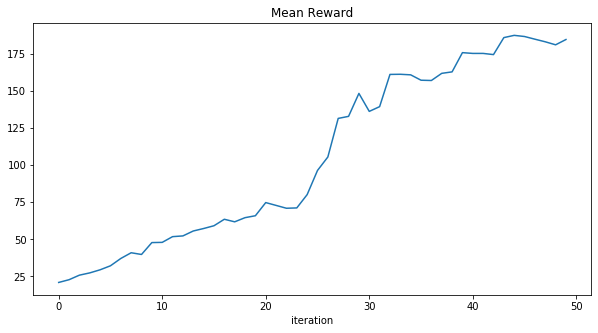

In [8]:
plt.figure(figsize=(10,5))
plt.plot(rewards)
plt.title('Mean Reward')
plt.xlabel('iteration')
plt.show()

# Gradient de politique "Recompense à venir"

Dans l'expression précédente de notre gradient, 

$$ \nabla_{\theta} J(\pi_{\theta}) = \underset{\tau \sim \pi_{\theta}}{E}\Bigg[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) R(\tau)\Bigg]  $$

On remarque que $R(\tau)$, la somme de toutes les récompenses déjà obtenues, est en facteur et donc chaque action est influencée par cette récompense *passée*. Ça n'a pas tellement de sense, les agents devraient renforcer les actions en se basant sur leurs conséquences *futures*.    


On peut utiliser comme gradient de politique, 

$$ \nabla_{\theta} J(\pi_{\theta}) = \underset{\tau \sim \pi_{\theta}}{E}\Bigg[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) \sum_{t'=t}^T R(s_{t'},a_{t'},s_{t'+1})\Bigg] $$

qui dépend des **récompenses à venir** des paires état-action.

|En quoi c'est mieux ?|
|:------|
| L'un des problèmes dans le calcul du gradient de politique est le nombre de trajectoire à tirer pour obtenir une estimation de faible variance. La première formulation inclut les récompenses passées qui ont une espérance nulle mais pas une variance nulle, ces termes ajoutent donc seulement du bruit à l'estimation du gradient|

## Exemple d'implémentation

Le principal changement par rapport à la précédente implémentation est dans la fonction de perte, désormais on utilise différents poids :

```python
# the weight for each logprob(a|s) is R(tau)
batch_weights += [ep_ret] * ep_len
```

**devient**

```python
# the weight for each logprob(a_t|s_t) is reward-to-go from t
batch_weights += list(reward_to_go(ep_rews))
```

In [9]:
def reward_to_go(rewards):
    n = len(rewards)
    rewards_futures = np.zeros_like(rewards)
    for i in reversed(range(n)):
        rewards_futures[i] = rewards[i] + (rewards_futures[i+1] if i+1 < n else 0)
    return rewards_futures

In [10]:
def train_one_epoch(render=False):
    
    # make some empty lists for logging.
    batch_obs     = []      # for observations
    batch_acts    = []      # for actions
    batch_weights = []      # for R(tau) weighting in policy gradient
    batch_rets    = []      # for measuring episode returns
    batch_lens    = []      # for measuring episode lengths

    # reset episode-specific variables
    observation = env.reset()   # first observation comes from starting distribution
    done        = False         # signal from environment that episode is over
    ep_rews     = []            # list for rewards accrued throughout epoch

    # render first episode of each epoch
    finished_rendering_this_epoch = False

    # collect experience by acting in the environment with current policy
    while True:

        # rendering
        if (not finished_rendering_this_epoch) and render:
            env.render()

        # save obs
        batch_obs.append(observation.copy())

        # action in the environment
        action = get_action(torch.as_tensor(observation, dtype=torch.float32))
        observation, reward, done, _ = env.step(action)

        # save action, reward
        batch_acts.append(action)
        ep_rews.append(reward)

        if done:
            # if episode is over, record info about episode
            ep_ret = sum(ep_rews) 
            ep_len = len(ep_rews)
            batch_rets.append(ep_ret)
            batch_lens.append(ep_len)

            # the weight for each logprob(a|s) is R(tau)
            batch_weights += [ep_ret] * ep_len

            # reset episode-specific variables
            observation = env.reset()
            done        = False
            ep_rews     = []

            # won't render again this epoch
            finished_rendering_this_epoch = True

            # end experience loop if we have enough of it
            if len(batch_obs) > batch_size:
                break

    # take a single policy gradient update step
    optimizer.zero_grad()
    observation = torch.as_tensor(batch_obs, dtype=torch.float32)
    action      = torch.as_tensor(batch_acts, dtype=torch.int32)
    weights     = torch.as_tensor(batch_weights, dtype=torch.float32)
    batch_loss  = compute_loss(observation, action, weights)
    batch_loss.backward()
    optimizer.step()
    
    return batch_loss, batch_rets, batch_lens

In [11]:
epochs = 50
render_each  = False
render_final = False
rewards = []

# training loop
for i in tqdm(range(epochs)):
    batch_loss, batch_rets, batch_lens = train_one_epoch(render_each)
    rewards.append(np.mean(batch_rets))
    
    if render_final and i==epochs-1:
        env.render()
       

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:28<00:00,  2.97s/it]


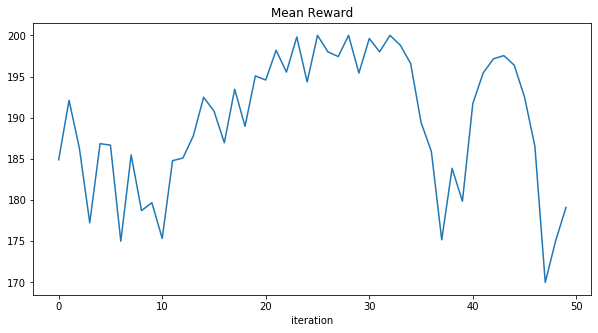

In [12]:
plt.figure(figsize=(10,5))
plt.plot(rewards)
plt.title('Mean Reward')
plt.xlabel('iteration')
plt.show()

# Référence dans le gradient de politique